Data Import and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import json
import os

In [3]:
# Load the datasets
train_data = pd.read_csv('data/train_product_data.csv')
test_data = pd.read_csv('data/test_data.csv')
test_results = pd.read_csv('data/test_results.csv')

In [5]:
# Display the first few rows of the training data
print(train_data.head())

# Check for missing values
missing_values = train_data.isnull().sum()
print("Missing values:\n", missing_values)

                            uniq_id            crawl_timestamp  \
0  c2d766ca982eca8304150849735ffef9  2016-03-25 22:59:23 +0000   
1  f449ec65dcbc041b6ae5e6a32717d01b  2016-03-25 22:59:23 +0000   
2  0973b37acd0c664e3de26e97e5571454  2016-03-25 22:59:23 +0000   
3  ce5a6818f7707e2cb61fdcdbba61f5ad  2016-03-25 22:59:23 +0000   
4  29c8d290caa451f97b1c32df64477a2c  2016-03-25 22:59:23 +0000   

                                         product_url  \
0  http://www.flipkart.com/alisha-solid-women-s-c...   
1  http://www.flipkart.com/aw-bellies/p/itmeh4grg...   
2  http://www.flipkart.com/alisha-solid-women-s-c...   
3  http://www.flipkart.com/alisha-solid-women-s-c...   
4  http://www.flipkart.com/dilli-bazaaar-bellies-...   

                                        product_name product_category_tree  \
0                Alisha Solid Women's Cycling Shorts             Clothing    
1                                         AW Bellies             Footwear    
2                Alisha Solid Wo

In [7]:
# Data Preprocessing
# Fill missing values for 'retail_price' and 'discounted_price' with median
train_data['retail_price'] = train_data['retail_price'].fillna(train_data['retail_price'].median())
train_data['discounted_price'] = train_data['discounted_price'].fillna(train_data['discounted_price'].median())

# Drop rows with missing 'image', 'description', 'brand', and 'product_specifications'
train_data = train_data.dropna(subset=['image', 'description', 'brand', 'product_specifications'])

# Ensure 'is_FK_Advantage_product' is a boolean
train_data['is_FK_Advantage_product'] = train_data['is_FK_Advantage_product'].astype(bool)

# Function to safely parse JSON strings
def safe_json_parse(x):
    try:
        return json.loads(x.replace("=>", ":"))
    except json.JSONDecodeError:
        return {}

# Convert 'product_specifications' from JSON string to dictionary
train_data['product_specifications'] = train_data['product_specifications'].apply(safe_json_parse)

# Encode the target variable
label_encoder = LabelEncoder()
train_data['product_category_tree'] = label_encoder.fit_transform(train_data['product_category_tree'])

# Handle missing values in the test set in a similar manner
test_data['retail_price'] = test_data['retail_price'].fillna(test_data['retail_price'].median())
test_data['discounted_price'] = test_data['discounted_price'].fillna(test_data['discounted_price'].median())
test_data = test_data.dropna(subset=['image', 'description', 'brand', 'product_specifications'])
test_data['is_FK_Advantage_product'] = test_data['is_FK_Advantage_product'].astype(bool)
test_data['product_specifications'] = test_data['product_specifications'].apply(safe_json_parse)

# Ensure the test set has the same features as the train set
assert set(train_data.columns) == set(test_data.columns) | {'product_category_tree'}

print("Data Preprocessing Complete.")

Data Preprocessing Complete.


Exploratory Data Analysis (EDA)


                                 uniq_id            crawl_timestamp  \
count                              10283                      10283   
unique                             10283                        237   
top     c2d766ca982eca8304150849735ffef9  2015-12-01 12:40:44 +0000   
freq                                   1                       1510   
mean                                 NaN                        NaN   
std                                  NaN                        NaN   
min                                  NaN                        NaN   
25%                                  NaN                        NaN   
50%                                  NaN                        NaN   
75%                                  NaN                        NaN   
max                                  NaN                        NaN   

                                              product_url  \
count                                               10283   
unique                   

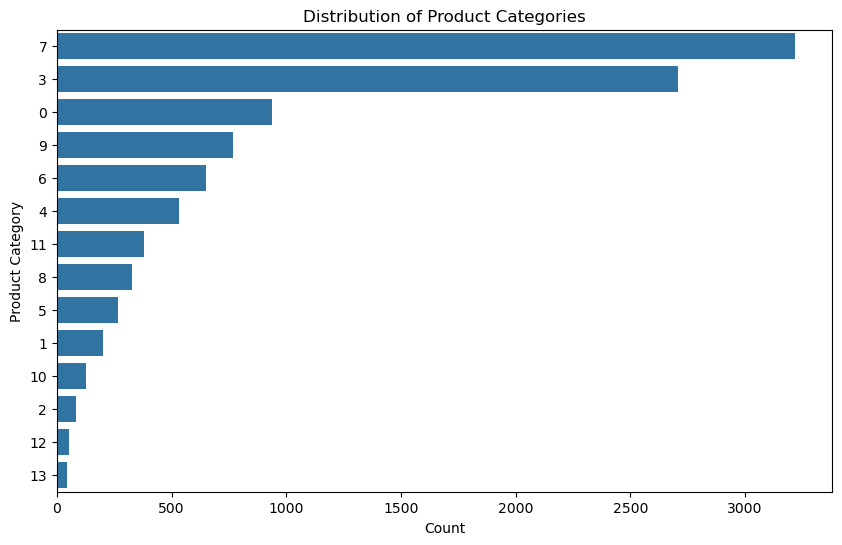

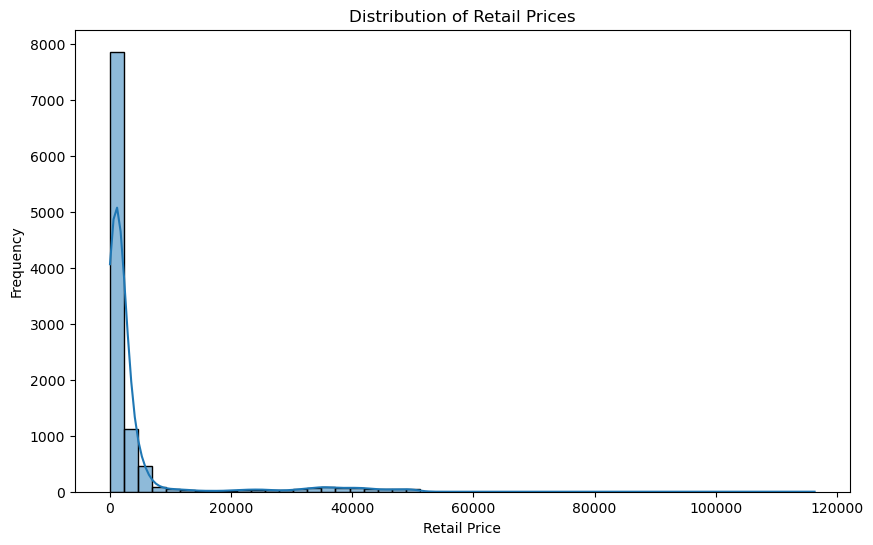

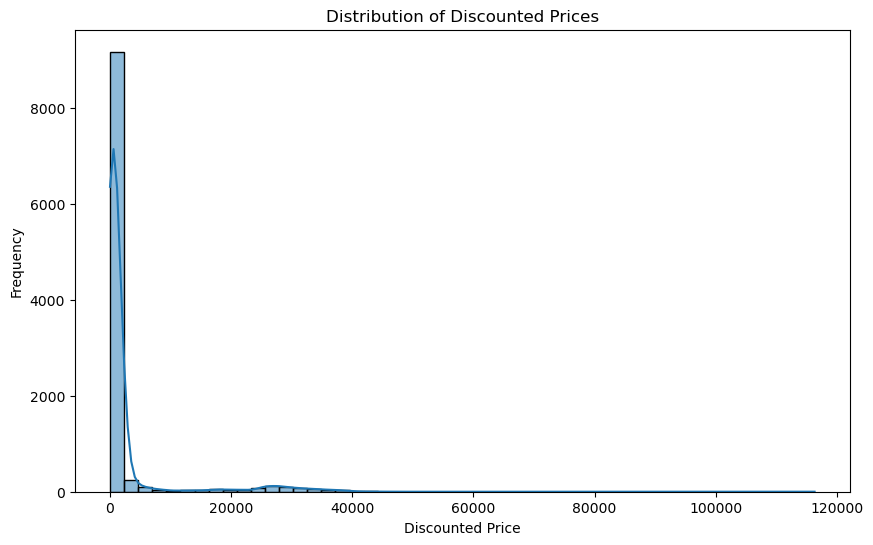

Exploratory Data Analysis Complete.


In [9]:
# Exploratory Data Analysis
# Summary statistics
print(train_data.describe(include='all'))

# Distribution of product categories
plt.figure(figsize=(10, 6))
sns.countplot(y=train_data['product_category_tree'], order=train_data['product_category_tree'].value_counts().index)
plt.title('Distribution of Product Categories')
plt.xlabel('Count')
plt.ylabel('Product Category')
plt.show()

# Distribution of retail prices
plt.figure(figsize=(10, 6))
sns.histplot(train_data['retail_price'], bins=50, kde=True)
plt.title('Distribution of Retail Prices')
plt.xlabel('Retail Price')
plt.ylabel('Frequency')
plt.show()

# Distribution of discounted prices
plt.figure(figsize=(10, 6))
sns.histplot(train_data['discounted_price'], bins=50, kde=True)
plt.title('Distribution of Discounted Prices')
plt.xlabel('Discounted Price')
plt.ylabel('Frequency')
plt.show()

print("Exploratory Data Analysis Complete.")

Feature Engineering / Text to Feature


In [15]:
# Combine 'product_name' and 'description' for text features
train_data['text_data'] = train_data['product_name'] + ' ' + train_data['description']
test_data['text_data'] = test_data['product_name'] + ' ' + test_data['description']

# Encode categorical features
categorical_features = ['brand', 'is_FK_Advantage_product']
train_data = pd.get_dummies(train_data, columns=categorical_features, drop_first=True)
test_data = pd.get_dummies(test_data, columns=categorical_features, drop_first=True)

# Ensure the test set has the same features as the train set
missing_cols = list(set(train_data.columns) - set(test_data.columns))
# Create a DataFrame with missing columns filled with zeros
missing_data = pd.DataFrame(0, index=test_data.index, columns=missing_cols)
# Concatenate the new columns to the test_data DataFrame
test_data = pd.concat([test_data, missing_data], axis=1)
# Reorder columns to match train_data
test_data = test_data[train_data.columns.drop('product_category_tree')]

print("Feature Engineering Complete.")

Feature Engineering Complete.


Machine Learning Model Building and Evaluation

In [17]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['product_category_tree', 'uniq_id', 'crawl_timestamp', 'product_url', 'image', 'pid', 'product_specifications']), 
                                                  train_data['product_category_tree'], test_size=0.2, random_state=42)

# Build a Pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Hyperparameter tuning
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train['text_data'], y_train)

# Best model
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_val['text_data'])
print("Model evaluation on validation set:\n", classification_report(y_val, y_pred, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))

# Cross-validation score
cv_scores = cross_val_score(best_model, X_train['text_data'], y_train, cv=5, scoring='f1_weighted')
print("Cross-validation F1 scores:", cv_scores)
print("Mean cross-validation F1 score:", np.mean(cv_scores))

print("Model Building and Evaluation Complete.")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Model evaluation on validation set:
                              precision    recall  f1-score   support

                Automotive        0.98      0.99      0.99       169
                 Baby Care        0.96      0.98      0.97        45
     Bags, Wallets & Belts        0.93      0.93      0.93        14
                  Clothing        1.00      0.99      1.00       557
                 Computers        0.98      0.96      0.97       110
                  Footwear        1.00      1.00      1.00        52
Home Decor & Festive Needs        0.99      0.99      0.99       143
                 Jewellery        1.00      1.00      1.00       631
          Kitchen & Dining        0.91      0.95      0.93        55
     Mobiles & Accessories        0.97      0.97      0.97       149
         Pens & Stationery        0.92      0.92      0.92        24
          Tools & Hardware        1.00      1.00      1.00        92
    T

Predictions and Submission


In [19]:
# Predict on test data
test_pred = best_model.predict(test_data['text_data'])

# Prepare the submission
submission = pd.DataFrame({'uniq_id': test_data['uniq_id'], 'predicted_category': label_encoder.inverse_transform(test_pred)})
submission.to_csv('submission.csv', index=False)

print("Predictions and Submission Complete.")

Predictions and Submission Complete.
